In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# AWS regions
names = [
    "us-east-1",      # US East (N. Virginia)
    "us-west-1",      # US West (N. California)
    "us-west-2",      # US West (Oregon)
    "af-south-1",     # Africa (Cape Town)
    "ap-south-2",     # Asia Pacific (Hyderabad)
    "ap-northeast-2", # Asia Pacific (Seoul)
    "ap-southeast-2", # Asia Pacific (Sydney)
    "ca-central-1",   # Canada (Central)
    "eu-central-1",   # Europe (Frankfurt)
    "eu-west-2",      # Europe (London)
    "eu-west-3",      # Europe (Paris)
    "eu-north-1",     # Europe (Stockholm)
    "sa-east-1",       # South America (São Paulo)
    "il-central-1"    # Israel (Tel Aviv)
]

# load latency measurements from csv
df = pd.read_csv("latencies.csv", index_col=0)
df.head()

,from,to,latency
datetime,,,
2024-07-03 20:00:41,eu-west-2,us-east-1,398
2024-07-03 20:00:47,eu-west-2,us-west-1,561
2024-07-03 20:00:50,eu-west-2,us-west-2,457
2024-07-03 20:00:54,eu-west-2,af-south-1,585
2024-07-03 20:00:58,eu-west-2,ap-south-2,555


[[  0.          44.05142297  74.07929527 378.39063531 377.07072201
  113.90238468 219.25308095 466.80996428  55.70629656  54.24779669
   53.06154437  61.31922514  58.60473872 137.54134718]
 [ 44.05142297   0.         267.79762911  81.09649831 424.46866093
   60.20592643  66.44234427  54.21164527  68.81032431  61.65607604
   64.36720025  98.3628731   81.82543429 367.65917856]
 [ 74.07929527 267.79762911   0.          81.71828885 430.6431515
   71.35498406  73.74816628  63.62826343  81.42671816  69.84131359
   71.87740783 102.40846791 103.46441217 380.34038306]
 [378.39063531  81.09649831  81.71828885   0.         180.49561224
  132.65753359 132.45065412 446.27644786  77.23694522  73.1047403
   72.41683298 120.15434386  75.30614098 393.49853542]
 [377.07072201 424.46866093 430.6431515  180.49561224   0.
   75.66225749  69.80928209 424.09862565  94.9015416  101.62122598
   97.08986181 105.86780811 105.61629815 381.80943496]
 [113.90238468  60.20592643  71.35498406 132.65753359  75.6622574

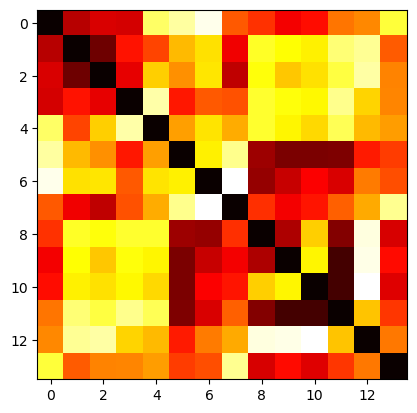

In [3]:
# compute average and std dev of latencies between the AWS regions and store them in a matrix
avg_distances = np.zeros((len(names), len(names)))
std_dev_distances = np.zeros((len(names), len(names)))
                     
for from_region in names:
    for to_region in names:
        if from_region == to_region:
            continue
        # filter the dataframe to get the latencies between the two regions
        latencies_from = df[(df['from'] == from_region) & (df['to'] == to_region)]['latency']
        latencies_to = df[(df['from'] == to_region) & (df['to'] == from_region)]['latency']
        # combine the two series
        latencies = pd.concat([latencies_from, latencies_to])
        # compute the average and std dev
        avg_distances[names.index(from_region), names.index(to_region)] = latencies.mean()
        avg_distances[names.index(to_region), names.index(from_region)] = latencies.mean()
        std_dev_distances[names.index(from_region), names.index(to_region)] = latencies.std()
        std_dev_distances[names.index(to_region), names.index(from_region)] = latencies.std()

# plot the distance matrix
plt.imshow(avg_distances, cmap='hot', interpolation='nearest')

# print the standard deviation matrix
print(std_dev_distances)

In [5]:
import random
import math
from collections import defaultdict

# use the FRT algorithm to embed a metric space into a hierarchically separated tree

class Node:
    def __init__(self, point):
        self.point = point
        self.children = []

class Tree:
    def __init__(self, root):
        self.root = root

def distance(point1, point2):
    return avg_distances[names.index(point1), names.index(point2)]

def ball(points, point, radius):
    """
    Return the set of points within the ball of the given radius centered at the given point.
    """
    point_set = set()
    for p in points:
        d = distance(point, p)
        if d <= radius:
            point_set.add(p)
    return point_set

def diameter(points):
    return max(distance(p1, p2) for p1 in points for p2 in points)

def frt_algorithm(points):
    diam = diameter(points)
    n = len(points)
    log_delta = np.ceil(np.log2(diam))

    # permute the points and save them in pi
    pi = np.random.permutation(points)

    # choose r_0
    radius_0 = np.random.uniform(0.5, 1)
    radius_0 = 1
    radii = [radius_0 * 2**i for i in range(1, int(log_delta) + 1)]

    # set of nodes at each level (dict)
    levels = defaultdict(list)
    ancestors = defaultdict(list)
    edgeweights = defaultdict(float)
    levels[log_delta] = [frozenset(points)]
    ancestors[log_delta] = None
    end = 1

    for i in reversed(range(1, int(log_delta)+1)):
        # get the sets of nodes at level i
        Cs = levels[i]
        # if the length of Cs is n, we are done
        if len(Cs) == n:
            end = i
            break
        # print("i: {}, Cs: {}".format(i,Cs))
        for C in Cs:
            # print("i: {}, C: {}".format(i,C))
            S = C.copy()
            for j in range(0, n):
                B = ball(points, pi[j], radii[i-1])
                # print("i: {}, C: {}, radius: {}, B: {}".format(i, C, radii[i-1], B))
                P = S.intersection(B)
                # if P is not empty...
                if len(P) > 0:
                    S = S.difference(P)
                    # add P to T as a child of C at level i-1
                    levels[i-1].append(frozenset(P))
                    ancestors[i-1].append(frozenset(C))
        edgeweights[i-1] = radii[i-1]

    # build the tree
    root = Node(frozenset(points))
    tree = Tree(root)
    cur_level = [root]
    completed = set()
    for i in reversed(range(end, int(log_delta))):
        next_level = []
        for C, parent in zip(levels[i], ancestors[i]):
            # get parent node from current level
            parent_node = None
            for node in cur_level:
                if node.point == parent:
                    parent_node = node
                    break
            # check if the parent and C are identical with length 1
            if parent == C and len(C) == 1:
                continue
            # create a new node
            new_node = Node(C)
            parent_node.children.append(new_node)
            next_level.append(new_node)
            # if C has length one, add it to the completed set and add an OFF state
            if len(C) == 1:
                completed.add(C)
                leaf_node = Node("OFF")
                new_node.children.append(leaf_node)
        cur_level = next_level
    
    return tree, edgeweights, log_delta
    

# Example usage:
points = names
# levels, ancestors = frt_algorithm(points)
tree, weights, levels = frt_algorithm(points)

def print_tree(node, level=0):
    if node:
        print(' ' * level * 10, str(list(node.point)))
        for child in node.children:
            print_tree(child, level + 1)

print_tree(tree.root)
# print(tree.root.children)

 ['us-east-1', 'ap-southeast-2', 'af-south-1', 'eu-central-1', 'eu-west-3', 'us-west-2', 'ap-northeast-2', 'ap-south-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'il-central-1', 'us-west-1', 'eu-north-1']
           ['us-east-1', 'ap-southeast-2', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'ap-northeast-2', 'ap-south-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'il-central-1', 'eu-west-3', 'eu-north-1']
                     ['us-east-1', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'eu-west-3', 'eu-north-1']
                               ['us-west-1', 'us-east-1']
                                         ['us-east-1']
                                                   ['O', 'F', 'F']
                                         ['us-west-1']
                                                   ['O', 'F', 'F']
                               ['eu-west-3', 'eu-west-2', 'eu-central-1', 'eu-north-1']
                            

In [43]:
print(weights)

defaultdict(<class 'float'>, {9: 1024, 8: 512, 7: 256, 6: 128, 5: 64, 4.0: 0.0})
[0, 1024, 512, 512, 256, 256, 256, 256, 256, 256, 256, 256, 256, 128, 128, 128, 128, 128, 1, 1, 128, 128, 1, 1, 1, 1, 1, 1, 64, 64, 1, 1, 1, 1, 1, 1]


In [42]:
weight_vector = [0]
# iterate through the tree using breadth first search, each time we encounter a node, we add the weight of the preceding edge to the weight vector
queue = [tree.root]
level_queue = [levels]
tau = 1
while queue:
    node = queue.pop(0)
    level = level_queue.pop(0)
    for child in node.children:
        if len(node.children) == 1 and child.point == "OFF":
            queue.append(child)
            level_queue.append(level-1)
            weight_vector.append(tau)
        else:
            queue.append(child)
            level_queue.append(level-1)
            weight_vector.append(weights[level-1])

In [44]:
print(weight_vector)

[0, 1024, 512, 512, 256, 256, 256, 256, 256, 256, 256, 256, 256, 128, 128, 128, 128, 128, 1, 1, 128, 128, 1, 1, 1, 1, 1, 1, 64, 64, 1, 1, 1, 1, 1, 1]


In [102]:
c_vector = [0]
name_vector = ["root"]
# iterate through the tree using breadth first search, each time we encounter a node, we add a 1 to the c vector if it is an ON node, otherwise we add a 0
queue = [tree.root]
level_queue = [levels]
while queue:
    node = queue.pop(0)
    level = level_queue.pop(0)
    for child in node.children:
        queue.append(child)
        level_queue.append(level-1)
        if len(child.point) == 1:
            c_vector.append(1)
            name_vector.append(list(child.point)[0])
        else:
            c_vector.append(0)
            string = str(list(node.point))
            if child.point == "OFF":
                string = list(node.point)[0] + " OFF"
            name_vector.append(string)

In [103]:
print(c_vector)
print(name_vector)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
['root', "['us-east-1', 'ap-southeast-2', 'af-south-1', 'eu-central-1', 'eu-west-3', 'us-west-2', 'ap-northeast-2', 'ap-south-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'il-central-1', 'us-west-1', 'eu-north-1']", "['us-east-1', 'ap-southeast-2', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'ap-northeast-2', 'ap-south-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'il-central-1', 'eu-west-3', 'eu-north-1']", "['us-east-1', 'ap-southeast-2', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'ap-northeast-2', 'ap-south-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'il-central-1', 'eu-west-3', 'eu-north-1']", "['us-east-1', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'eu-west-3', 'eu-north-1']", "['us-east-1', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'eu

In [104]:
def distance_in_tree(tree, weights, levels, point1, point2):
    # search for shortest path between point1 and point2 in the tree
    # first, find the lowest (in terms of level) node which contains both point1 and point2 in name
    level = levels
    root = tree.root
    prev_root = None
    while root != prev_root:
        prev_root = root
        for child in root.children:
            if point1 in child.point and point2 in child.point:
                level = level - 1
                root = child
                break
    
    print(root.point)
    # print(weights[level-1])

    # now, we have the lowest common ancestor of point1 and point2
    # we can compute the distance between point1 and point2 by summing the weights of the edges from point1 to the LCA and from the LCA to point2
    distance_to_point1 = weights[level-1]
    distance_to_point2 = weights[level-1]
    found_point1 = False
    found_point2 = False
    root_point1 = root
    root_point2 = root
    level_point1 = level-2
    level_point2 = level-2
    while not found_point1:
        for child in root_point1.children:
            if str(list(child.point)) == "['{}']".format(point1):
                found_point1 = True
                break
            if point1 in child.point:
                root_point1 = child
                distance_to_point1 += weights[level_point1]
                break
        level_point1 -= 1
    while not found_point2:
        for child in root_point2.children:
            if str(list(child.point)) == "['{}']".format(point2):
                found_point2 = True
                break
            if point2 in child.point:
                root_point2 = child
                distance_to_point2 += weights[level_point2]
                break
        level_point2 -= 1
    return distance_to_point1 + distance_to_point2


distance_in_tree(tree, weights, levels, "us-east-1", "us-west-1")

frozenset({'us-west-1', 'us-east-1'})


256

In [105]:
8*np.log2(14)

30.458839376460833

In [106]:
distance("us-east-1", "us-west-1")

221.0427046263345

In [107]:
# weighted_l1_norm computes the weighted L1 norm between two vectors.
def weighted_l1_norm(vector1, vector2, weights, cvxpy=False):
    if cvxpy:
        weighted_diff = cp.multiply(cp.abs(vector1 - vector2), weights)
        weighted_sum = cp.sum(weighted_diff)
    else:
        assert vector1.shape == vector2.shape == weights.shape, "Input arrays must have the same shape."

        weighted_diff = np.abs(vector1 - vector2) * weights
        weighted_sum = np.sum(weighted_diff)

    return weighted_sum

In [108]:
us_east_1_vector = np.zeros_like(weight_vector, dtype=float)
us_west_1_vector = np.zeros_like(weight_vector, dtype=float)
us_east_1_vector[0] = 1
us_west_1_vector[0] = 1
for i, name in enumerate(name_vector):
    if "us-east-1" in name and "OFF" not in name:
        us_east_1_vector[i] = 1
    if "us-west-1" in name and "OFF" not in name:
        us_west_1_vector[i] = 1

us_east_1_vector[name_vector.index('us-east-1 OFF')] = 0.4

weighted_l1_norm(us_east_1_vector, us_west_1_vector, np.array(weight_vector))

256.4

In [109]:
print(name_vector)
print(name_vector.index('us-east-1 OFF'))

['root', "['us-east-1', 'ap-southeast-2', 'af-south-1', 'eu-central-1', 'eu-west-3', 'us-west-2', 'ap-northeast-2', 'ap-south-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'il-central-1', 'us-west-1', 'eu-north-1']", "['us-east-1', 'ap-southeast-2', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'ap-northeast-2', 'ap-south-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'il-central-1', 'eu-west-3', 'eu-north-1']", "['us-east-1', 'ap-southeast-2', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'ap-northeast-2', 'ap-south-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'il-central-1', 'eu-west-3', 'eu-north-1']", "['us-east-1', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'eu-west-3', 'eu-north-1']", "['us-east-1', 'us-west-1', 'af-south-1', 'eu-central-1', 'us-west-2', 'eu-west-2', 'ca-central-1', 'sa-east-1', 'eu-west-3', 'eu-north-1']", 'af-south-1', 'sa-east-1', "['us-east-1', 'us-west-1', 'af-south-1', 'eu-central-1'

In [110]:
print(us_east_1_vector)

[1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [111]:
# define some simplex vectors
simplex_names = []
for name in names:
    simplex_names.append(name + " ON")
    simplex_names.append(name + " OFF")

print(simplex_names)

['us-east-1 ON', 'us-east-1 OFF', 'us-west-1 ON', 'us-west-1 OFF', 'us-west-2 ON', 'us-west-2 OFF', 'af-south-1 ON', 'af-south-1 OFF', 'ap-south-2 ON', 'ap-south-2 OFF', 'ap-northeast-2 ON', 'ap-northeast-2 OFF', 'ap-southeast-2 ON', 'ap-southeast-2 OFF', 'ca-central-1 ON', 'ca-central-1 OFF', 'eu-central-1 ON', 'eu-central-1 OFF', 'eu-west-2 ON', 'eu-west-2 OFF', 'eu-west-3 ON', 'eu-west-3 OFF', 'eu-north-1 ON', 'eu-north-1 OFF', 'sa-east-1 ON', 'sa-east-1 OFF', 'il-central-1 ON', 'il-central-1 OFF']


In [112]:
# convert us_east_1_vector into a corresponding simplex vector
us_east_1_simplex_vector = np.zeros(len(simplex_names))
for i, value in enumerate(us_east_1_vector):
    if name_vector[i] == "us-east-1":
        us_east_1_simplex_vector[simplex_names.index("us-east-1 ON")] = value - us_east_1_vector[name_vector.index('us-east-1 OFF')]
    if name_vector[i] == "us-east-1 OFF":
        us_east_1_simplex_vector[simplex_names.index("us-east-1 OFF")] = value

In [114]:
# convert us_east_1_vector into a corresponding simplex vector (indexing version)
us_east_1_simplex_vector = np.zeros(len(simplex_names))
us_east_1_simplex_vector[simplex_names.index("us-east-1 ON")] = us_east_1_vector[name_vector.index('us-east-1')] - us_east_1_vector[name_vector.index('us-east-1 OFF')]
us_east_1_simplex_vector[simplex_names.index("us-east-1 OFF")] = us_east_1_vector[name_vector.index('us-east-1 OFF')]

In [115]:
print(us_east_1_simplex_vector)

[0.6 0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [116]:
# convert ANY regular vector into a simplex vector
def convert_to_simplex(vector, names, vector_names, simplex_names):
    simplex_vector = np.zeros(len(simplex_names))
    for name in names:
        simplex_vector[simplex_names.index(name + " ON")] = vector[vector_names.index(name)] - vector[vector_names.index(name + " OFF")]
        simplex_vector[simplex_names.index(name + " OFF")] = vector[vector_names.index(name + " OFF")]
    return simplex_vector

convert_to_simplex(us_east_1_vector, names, name_vector, simplex_names)

array([0.6, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ])

In [122]:
# convert ANY simplex vector into a regular vector
def convert_to_regular(simplex_vector, names, vector_names, simplex_names):
    vector = np.zeros(len(vector_names))
    vector[0] = 1
    for name in names:
        name_index = vector_names.index(name)
        name_OFF_index = vector_names.index(name + " OFF")
        cumulative = simplex_vector[simplex_names.index(name + " ON")] + simplex_vector[simplex_names.index(name + " OFF")]
        vector[name_index] = cumulative
        vector[name_OFF_index] = simplex_vector[simplex_names.index(name + " OFF")]
        for i, vector_name in enumerate(vector_names):
            if i in [name_index, name_OFF_index]:
                continue
            if name in vector_name:
                vector[i] += cumulative
    return vector

convert_to_regular(us_east_1_simplex_vector, names, name_vector, simplex_names)

array([1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ,
       1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [123]:
print(np.array(us_east_1_vector))

[1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
